In [1]:
import concurrent.futures
import itertools
import os
import pathlib
import random
import re
import typing
from functools import partial
from itertools import product
import time

import numpy as np
import orjson
import pandas as pd
import requests
import xmltodict
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(10)

# Explore the PG index

In [2]:
# download the index
# csv_url = 'https://www.gutenberg.org/cache/epub/feeds/pg_catalog.csv'
# df = pd.read_csv(csv_url)

df = pd.read_csv("pg_catalog.csv")

/var/folders/n9/04fxpc3d4dn4s513dwth10b80000gn/T/ipykernel_34140/3300648097.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("pg_catalog.csv")


In [3]:
df.iloc[:5]

,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves
0,1,Text,1971-12-01,The Declaration of Independence of the United ...,en,"Jefferson, Thomas, 1743-1826","United States -- History -- Revolution, 1775-1...",E201; JK,Politics; American Revolutionary War; United S...
1,2,Text,1972-12-01,The United States Bill of Rights\r\nThe Ten Or...,en,United States,Civil rights -- United States -- Sources; Unit...,JK; KF,Politics; American Revolutionary War; United S...
2,3,Text,1973-11-01,John F. Kennedy's Inaugural Address,en,"Kennedy, John F. (John Fitzgerald), 1917-1963",United States -- Foreign relations -- 1961-196...,E838,NaN
3,4,Text,1973-11-01,Lincoln's Gettysburg Address\r\nGiven November...,en,"Lincoln, Abraham, 1809-1865",Consecration of cemeteries -- Pennsylvania -- ...,E456,US Civil War
4,5,Text,1975-12-01,The United States Constitution,en,United States,United States -- Politics and government -- 17...,JK; KF,United States; Politics; American Revolutionar...


In [4]:
# sometimes LoCC contains multiple ; separated annotations ... split these
f = lambda x: [token.strip() for token in str(x).split(';')]
df['locc_'] = df['LoCC'].map(f)

In [5]:
# how many entries in the en/PS/fiction catagory?
en = df.loc[(df.loc[:, 'Type']=='Text') & (df.loc[:, 'Language']=='en'),:]
print(f'en: {len(en)}')

f = lambda x: len(set(x).intersection(['PS'])) > 0
en_PS = df.loc[(df.loc[:, 'Type']=='Text') & (df.loc[:, 'Language']=='en') & (df.loc[:, 'locc_'].map(f)), :]
print(f'en_PS: {len(en_PS)}')

f = lambda x: len(set(x).intersection(['PS'])) > 0
g = lambda x: 'fiction' in str(x) or 'Fiction' in str(x)
en_PS_fiction = df.loc[(df.loc[:, 'Type']=='Text') & (df.loc[:, 'Language']=='en') & (df.loc[:, 'locc_'].map(f)) & (df.loc[:, 'Subjects'].map(g)), :]
print(f'en_PS_fiction: {len(en_PS_fiction)}')

en: 57340
en_PS: 11116
en_PS_fiction: 8760


# pull texts from PG

## select a subset

In [6]:
# NOTE: you could sample here a reduced number here ...
f = lambda x: len(set(x).intersection(['PS'])) > 0
g = lambda x: 'fiction' in str(x) or 'Fiction' in str(x)
df_subset = df.loc[(df.loc[:, 'Type']=='Text') & (df.loc[:, 'Language']=='en') & (df.loc[:, 'locc_'].map(f)) & (df.loc[:, 'Subjects'].map(g)), :]
print(f'en_PS_fiction: {len(df_subset)}')

en_PS_fiction: 8760


## pull the the subset

### test case ... finding the latest available .txt file for the book

In [7]:
# test case
book_url = 'http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/6/5/2/6526'
r = requests.get(book_url)
doc_names = sorted(re.findall(f'"(\d+-\d+\.txt?)"', r.text))
doc_names

['6526-8.txt']

### add each book url to the dataframe

(takes about 20 mins)

In [ ]:
def create_url(textid)->str:
    
    base_url = (
        "http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg"
    )
    
    f = lambda number: "/".join([c for c in str(textid)[:-1]]) + f"/{textid}"
    book_url = f"{base_url}/{f(textid)}"
    
    # get list of .txt to be found for each book, sorted
    try:
        r = requests.get(book_url)
        time.sleep(0.01)  # let's try not to overload the servers!
        txt_names = sorted(re.findall(f'"(\d+(?:-\d+)*\.txt?)"', r.text))

        return book_url + '/' + txt_names[-1]
    except:
        return ''
    
# test case ... 66666 as previous
[create_url(textid) for textid in tqdm(['66666'])]

# pull all books in subset
ids: list[str] = [str(x).strip() for x in df_subset['Text#'].values]
df_subset['book_url'] =  [create_url(textid) for textid in tqdm(ids)]

In [88]:
df_subset.to_csv('book_urls.csv')

### or load an existing book_urls.csv file

In [2]:
df_subset = pd.read_csv('book_urls.csv')

### how well have we done?

In [3]:
# # check the last ... if it tallies, then the preceding should too
display(df_subset.loc[8759, 'Title'])
display(df_subset.loc[8759, 'book_url'])
display(df_subset.loc[8759, 'Text#'])

# get whole-dataframe ... how big is it?
df_subset.loc[df_subset.loc[:, 'book_url']!='',:]  # subset of not--failed 

'A private chivalry'

'http://www.mirrorservice.org/sites/ftp.ibiblio.org/pub/docs/books/gutenberg/7/2/8/4/72849/72849-0.txt'

72849

,Unnamed: 0.1,Unnamed: 0,Text#,Type,Issued,Title,Language,Authors,Subjects,LoCC,Bookshelves,locc_,book_url
0,0,14,15,Text,1991-05-01,"Moby-Dick; or, The Whale",en,"Melville, Herman, 1819-1891",Whaling -- Fiction; Sea stories; Psychological...,PS,Best Books Ever Listings; Adventure,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
1,1,23,24,Text,2008-06-27,O Pioneers!,en,"Cather, Willa, 1873-1947",Nebraska -- Fiction; Historical fiction; Front...,PS,NaN,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
2,2,31,32,Text,2008-06-27,Herland,en,"Gilman, Charlotte Perkins, 1860-1935",Utopias -- Fiction; Women -- Fiction; Utopian ...,PS,Best Books Ever Listings,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
3,3,32,33,Text,1992-06-01,The Scarlet Letter,en,"Hawthorne, Nathaniel, 1804-1864",Adultery -- Fiction; Historical fiction; Reven...,PS,Harvard Classics; Movie Books,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
4,4,40,41,Text,2008-06-27,The Legend of Sleepy Hollow,en,"Irving, Washington, 1783-1859",Ghosts -- Fiction; New York (State) -- History...,PS,Children's Literature; Harvard Classics,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8900,72730,72811,Text,2024-01-29,A winter in retirement,en,"Washburn, Hannah Blaney","Rome -- History -- Nero, 54-68 -- Fiction; Chr...",PS,NaN,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
8756,8901,72733,72814,Text,2024-01-29,An imperial lover,en,"Taylor, Mary Imlay, 1878-1938","Courts and courtiers -- Fiction; Peter I, Empe...",PS,NaN,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
8757,8902,72745,72826,Text,2024-01-30,The foster-sisters,en,"Guernsey, Lucy Ellen, 1826-1899",Historical fiction; Young women -- Fiction; Ev...,PS,NaN,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...
8758,8903,72747,72828,Text,2024-01-30,A candle in the wind,en,"Taylor, Mary Imlay, 1878-1938",Man-woman relationships -- Fiction; Explorers ...,PS,NaN,['PS'],http://www.mirrorservice.org/sites/ftp.ibiblio...


**we have the full quota of 8760! yay!**

### pull the urls and save

(takes about 20 mins)

In [93]:
ids: list[str] = [str(x).strip() for x in df_subset['Text#'].values]
urls: list[str] = df_subset['book_url'].values
    
save_dir = pathlib.Path('/Users/PATH_TO/PG_en_PS_fiction_050204').expanduser().resolve()
save_dir.mkdir(exist_ok=True, parents=True)

failed_ids = []
for textid, book_url in tqdm(zip(ids, urls)):
    try:
        r = requests.get(book_url).content
        time.sleep(0.01)
        if r:
            with open(save_dir / f"{textid}.txt", 'wb') as f:
                f.write(r)
    except:
        failed_ids.append(textid)

8760it [24:38,  5.93it/s]


In [95]:
# get ids which we failed to fetch
failed_ids

['8716']

Note: 8716 retrospectively downloaded and added

Total 8760 books downloaded

# what's the distribution of author dates

In [39]:
starts = []
ends = []
unknowns = 0
for author in tqdm(df_subset['Authors'].values):
    if author:
        match = re.search(r'(\d+)-(\d+)', str(author))
        if match:
            start, end = match.groups()
            starts.append(start)
            ends.append(end)
        else:
            unknowns += 1
#             print(author)
    else:
        unknowns+=1
#         print(author)
        
# convert to ints
starts = [int(start) for start in starts]
ends = [int(end) for end in ends]

100%|███████████████████████████████████| 8760/8760 [00:00<00:00, 373702.98it/s]


In [37]:
unknowns

876

(array([  12.,   64.,  222.,  300.,  979., 1771., 1836.,  548., 1365.,
         787.]),
 array([1759. , 1777.1, 1795.2, 1813.3, 1831.4, 1849.5, 1867.6, 1885.7,
        1903.8, 1921.9, 1940. ]),
 <BarContainer object of 10 artists>)

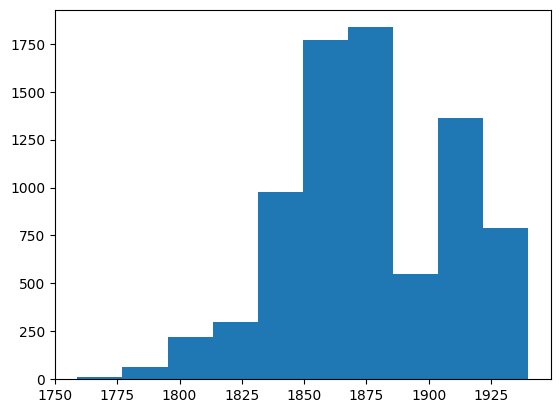

In [41]:
plt.hist(starts)

(array([9.000e+00, 2.000e+00, 1.010e+02, 1.550e+02, 6.920e+02, 1.698e+03,
        2.104e+03, 1.186e+03, 1.194e+03, 7.430e+02]),
 array([1793., 1816., 1839., 1862., 1885., 1908., 1931., 1954., 1977.,
        2000., 2023.]),
 <BarContainer object of 10 artists>)

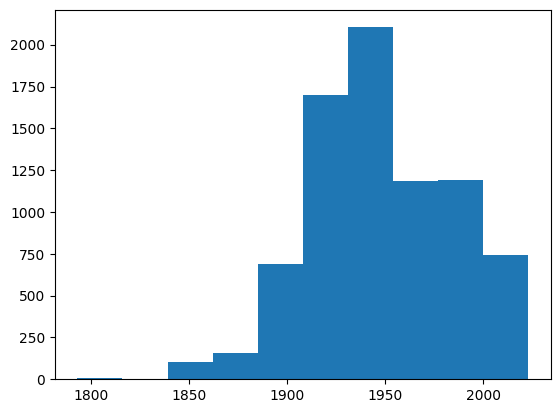

In [42]:
plt.hist(ends)